# Time Series Analysis Handbook

This notebook provides an overview of time series analysis **using the `darts` library**. We'll cover:

- **Forecasting Methods**: From simple baseline models to advanced deep learning approaches
- **Anomaly Detection**: Statistical and machine learning methods for identifying unusual patterns

👉 [`darts` api](http://unit8co.github.io/darts/index.html)

## 1. Setup and Data Preparation 🧑‍🍳

First, we'll import necessary libraries, initialize some utils functions and load the datasets we'll use.

In [1]:
# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Darts imports
from darts import TimeSeries
from darts.datasets import AusBeerDataset
from darts.metrics import mape, rmse, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

# Import forecasting models
from darts.models import (
    NaiveSeasonal, NaiveDrift, ExponentialSmoothing,
    ARIMA,
    LinearRegressionModel,
    RNNModel, BlockRNNModel,
    TransformerModel
)

# Import anomaly detection tools
from darts.ad import QuantileDetector
from darts.ad.scorers import NormScorer, KMeansScorer


Importing plotly failed. Interactive plots will not work.


In [3]:
import matplotlib.pyplot as plt
from style import MyStyle

def plot_multiple_series(xs, ys, labels, colors, output_file=None):
    """
    Plots multiple series on the same figure.

    Parameters:
    - xs: The x-axis values (shared across all series).
    - ys: A list of y-axis values (one for each series).
    - labels: A list of labels for each series.
    - colors: A list of colors for each series.
    - output_file: Optional. If provided, saves the plot to the specified file.
    """
    plt.figure(figsize=(20, 8))
    for x, y, label, color in zip(xs, ys, labels, colors):
        plt.plot(x, y, label=label, color=color, linewidth=3)
    plt.legend()
    MyStyle().apply()
    plt.tight_layout()
    if output_file:
        plt.savefig(output_file, dpi=300)
    plt.show()
    
from IPython.display import display, Markdown, Latex
display(Markdown("""
- `plot_multiple_series` allow to plots with ease.   
"""))


- `plot_multiple_series` allow to plots with ease.   


## 2. Dataset Decomposition 🍺

**AusBeerDataset** is a dataset containing the data of beer production in 🇦🇺 from 1960 to 2010.

We will view it and extract some data: the trend and the seasonality.

- **Trend**: Represents the long-term movement in the data. It shows the general direction in which the data is moving over time (e.g., upward or downward). We will extract it using the function `extract_trend_and_seasonality`, that use a very naive method: a convulutive filter that basically smooth the data.
- **Seasonality**: Represents recurring patterns or cycles in the data that occur at regular intervals (e.g., monthly, yearly).
- **Residuals**: What remains removing the trend and seasonality. 

Note that we scale the data to normalize it.

In [4]:
series = AusBeerDataset().load()
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
df = series_scaled.to_dataframe()
trend, seasonal = extract_trend_and_seasonality(series_scaled, model=ModelMode.ADDITIVE, freq=12)
residual = series_scaled - trend - seasonal
residual_pd = residual.to_series()
trend_pd = trend.to_series()
seasonal_pd = seasonal.to_series()

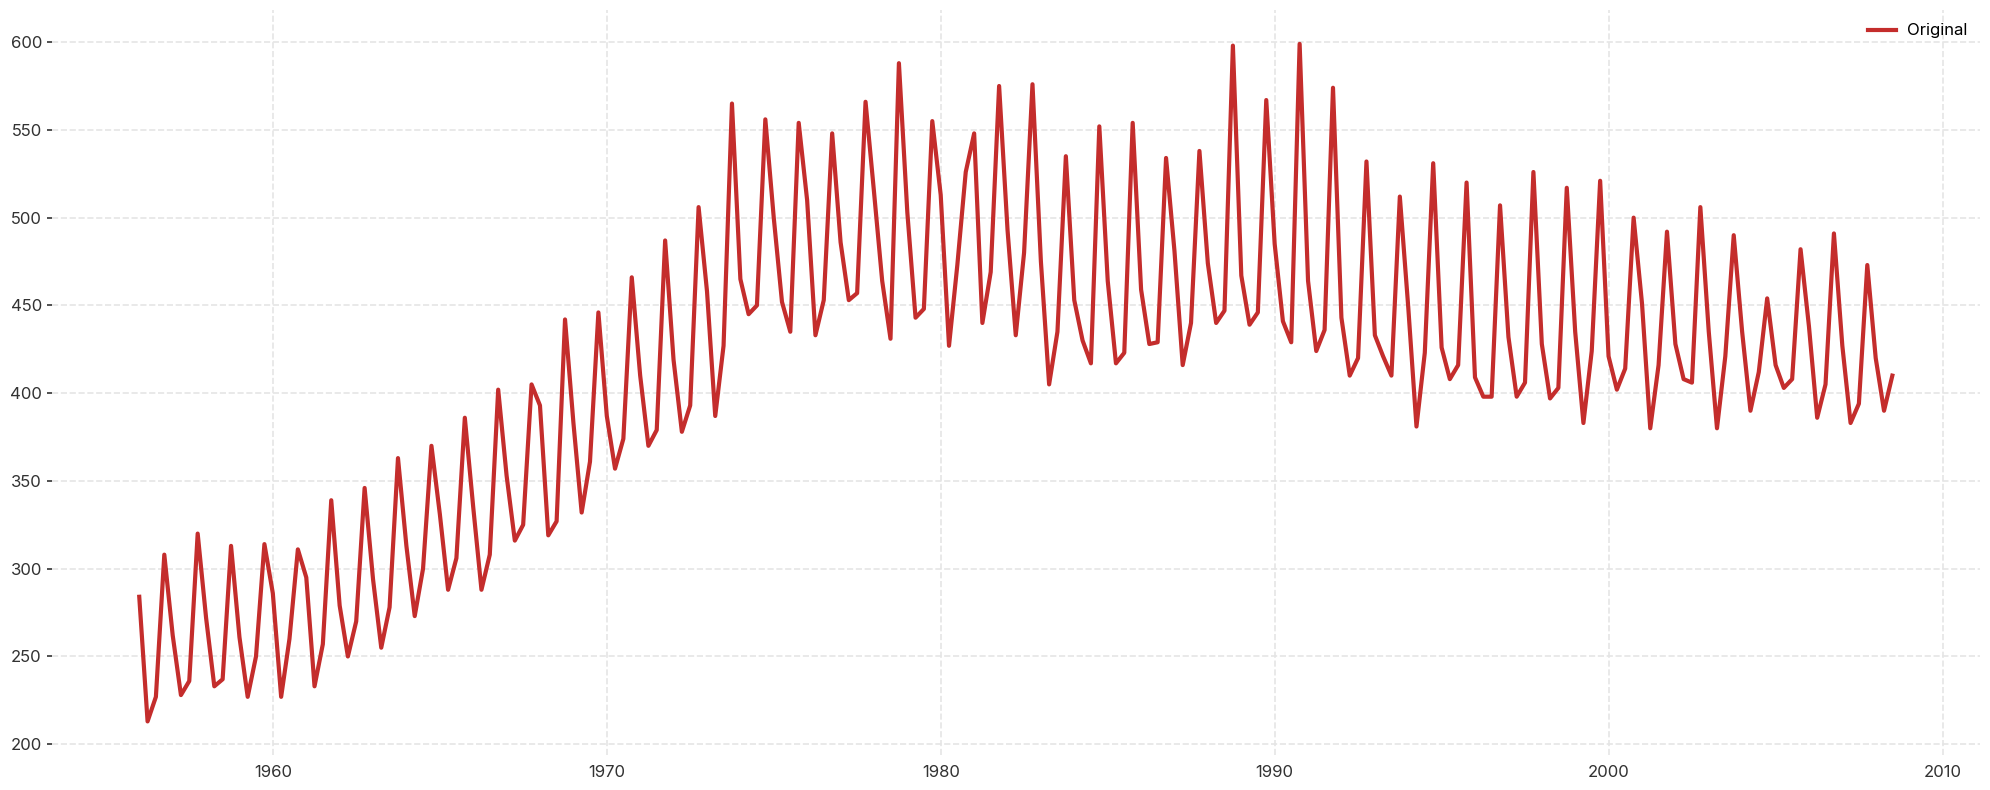

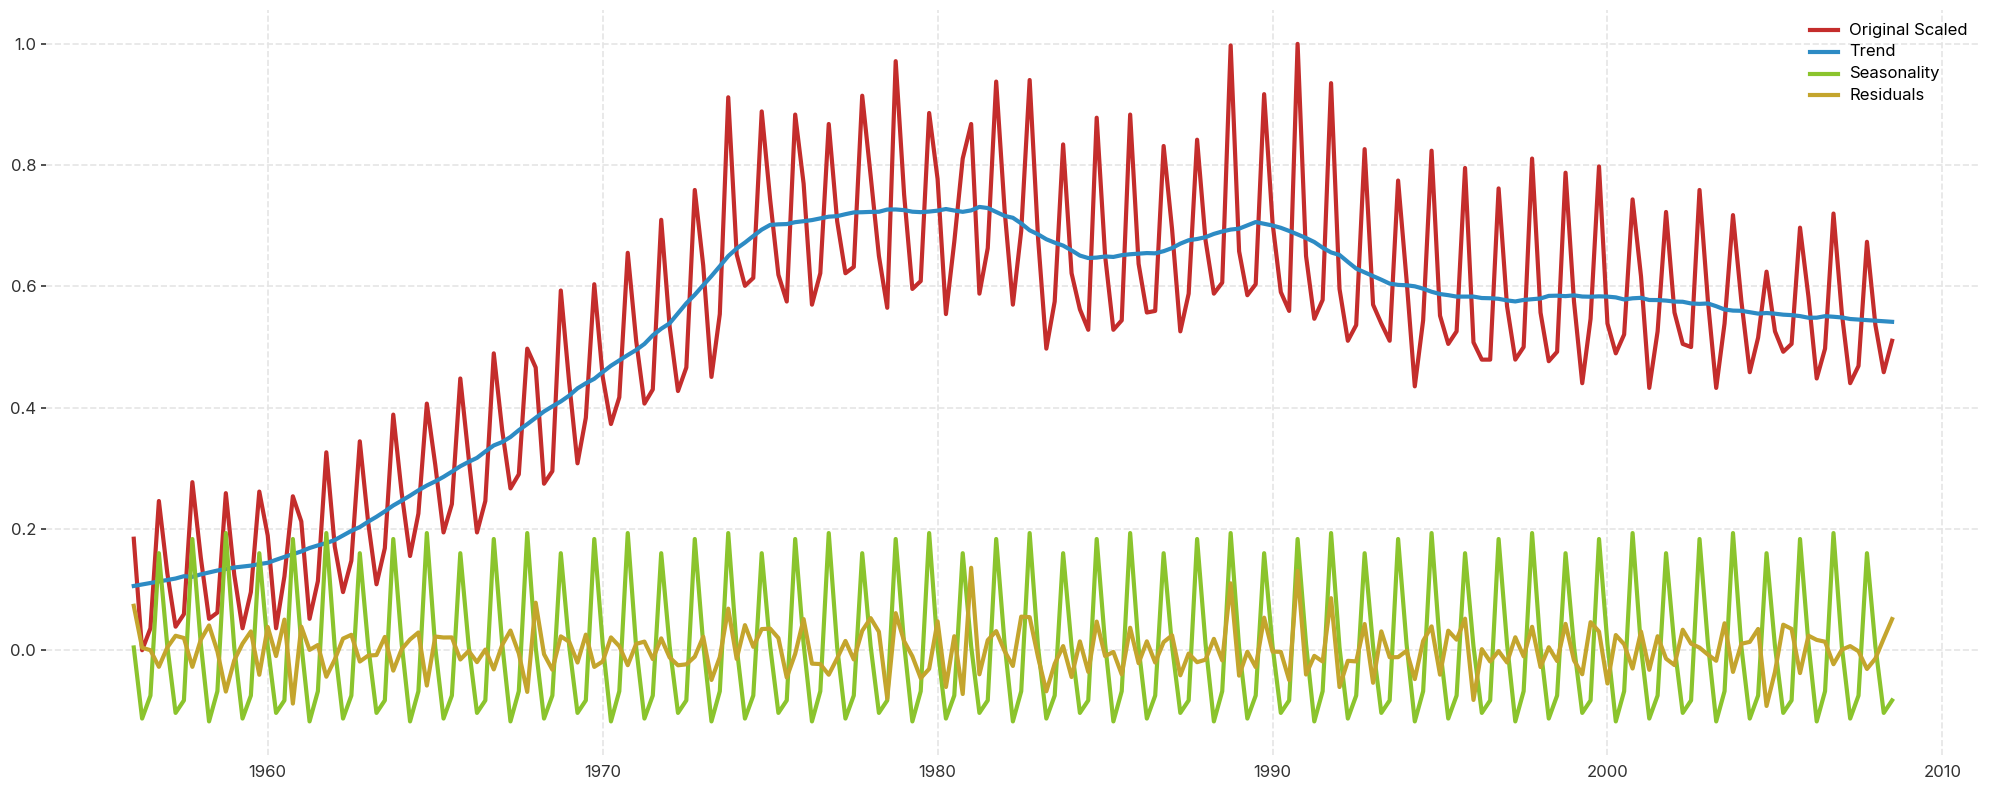

In [5]:
plot_multiple_series(
    xs=[series.time_index],
    ys=[series.values()],
    labels=['Original'],
    colors=[MyStyle.Palette.RED],
)

plot_multiple_series(
    xs=[df.index, trend_pd.index, seasonal_pd.index, residual_pd.index],
    ys=[df.iloc[:, 0], trend_pd.values, seasonal_pd.values, residual_pd.values],
    labels=['Original Scaled', 'Trend', 'Seasonality', 'Residuals'],
    colors=[MyStyle.Palette.RED, MyStyle.Palette.BLUE, MyStyle.Palette.YELLOW_GREEN, MyStyle.Palette.YELLOW_ORANGE],
    output_file='beer_production_trend_seasonality.png'
)


## 3. Forecasting Methods 🔮

### 3.1 Naive Forecasting

Naive methods serve as baseline models. They are simple but surprisingly effective for certain data patterns.

#### 3.1.1 Last Value (Naive Forecast)
The simplest approach: use the last observed value as the forecast.

**Mathematical Formulation:**
$$
\hat{y}_{t+h} = y_t
$$

where $\hat{y}_{t+h}$ is the forecast at time $t+h$, and $y_t$ is the last observed value.

#### 3.1.2 Drift Method
Allows for a linear trend by drawing a line between the first and last observation.

**Mathematical Formulation:**
$$
\hat{y}_{t+h} = y_t + \frac{h}{t-1} \sum_{i=2}^{t} (y_i - y_{i-1})
$$

#### 3.1.3 Simple Exponential Smoothing
Weighted average of past observations with exponentially decreasing weights.

**Mathematical Formulation:**
$$
\hat{y}_{t+1} = \alpha y_t + (1 - \alpha)\hat{y}_t
$$

where $\alpha \in [0,1]$ is the smoothing parameter.

Train size: 169, Test size: 42

Naive Drift MAPE: 19.13%
Naive Seasonal MAPE: 7.29%
Exponential Smoothing MAPE: 5.80%


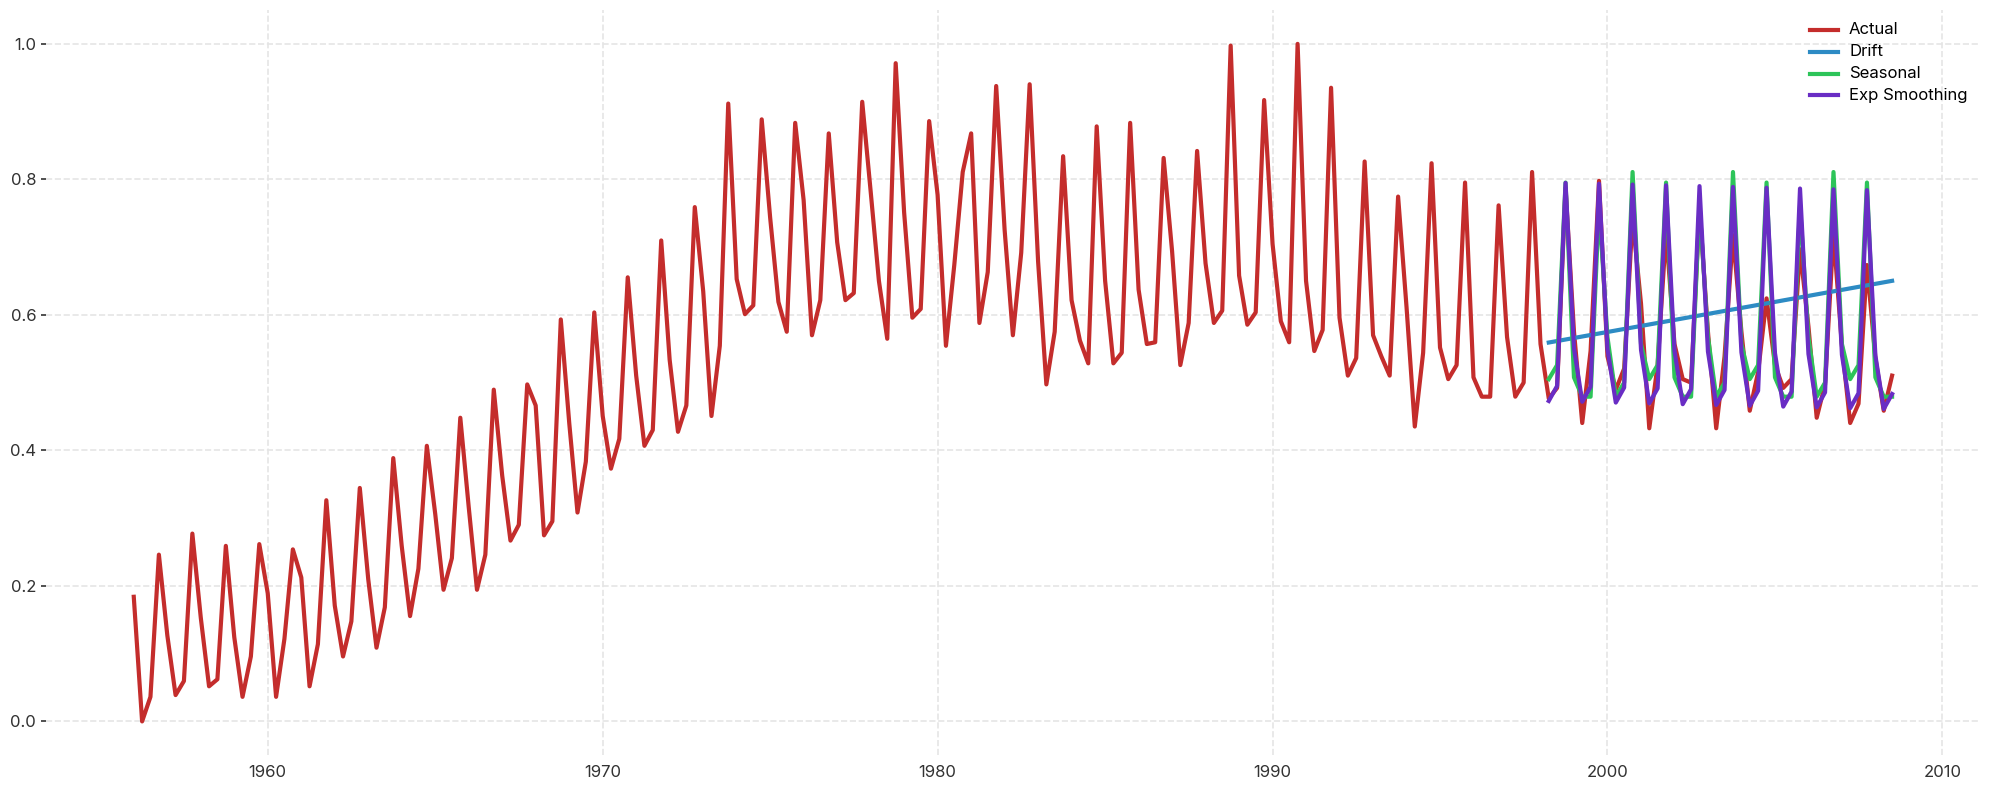

In [6]:
train, test = series_scaled.split_after(0.8)
print(f"Train size: {len(train)}, Test size: {len(test)}")

# Initialize naive models
naive_drift = NaiveDrift()
naive_seasonal = NaiveSeasonal(K=12)  
exp_smoothing = ExponentialSmoothing()

# Train and forecast
naive_drift.fit(train)
pred_drift = naive_drift.predict(len(test))

naive_seasonal.fit(train)
pred_seasonal = naive_seasonal.predict(len(test))

exp_smoothing.fit(train)
pred_exp = exp_smoothing.predict(len(test))

# Calculate errors
mape_drift = mape(test, pred_drift)
mape_seasonal = mape(test, pred_seasonal)
mape_exp = mape(test, pred_exp)

print(f"\nNaive Drift MAPE: {mape_drift:.2f}%")
print(f"Naive Seasonal MAPE: {mape_seasonal:.2f}%")
print(f"Exponential Smoothing MAPE: {mape_exp:.2f}%")

# Visualize using the plot_multiple_series function
plot_multiple_series(
    xs=[series_scaled.time_index, pred_drift.time_index, pred_seasonal.time_index, pred_exp.time_index],
    ys=[series_scaled.values(), pred_drift.values(), pred_seasonal.values(), pred_exp.values()],
    labels=['Actual', 'Drift', 'Seasonal', 'Exp Smoothing'],
    colors=[MyStyle.Palette.RED, MyStyle.Palette.BLUE, MyStyle.Palette.GREEN, MyStyle.Palette.PURPLE]
)


**Interpretation:**
- **Naive Drift** captures linear trends but misses seasonality
- **Naive Seasonal** works well when strong seasonal patterns exist
- **Exponential Smoothing** balances recent and historical data, providing smooth forecasts

### 3.2 Statistical Models Fore

#### 3.2.1 ARIMA (AutoRegressive Integrated Moving Average)

ARIMA is a widely-used statistical model that combines autoregression, differencing, and moving averages to model temporal dependencies.

**Mathematical Formulation:**

An `ARIMA(p, d, q)` model is defined as:

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} - \delta_1 \Delta y_{t-1} - \delta_2 \Delta y_{t-2} - ... - \delta_d \Delta y_{t-d} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}
$$



where:
- $p$ = order of the autoregressive part
- $d$ = degree of first differencing involved
- $q$ = order of the moving average part  

In addition:
- $c$ = constant term
- $\phi_i$ = autoregressive (AR) coefficients
- $\Delta y_t$ = differenced series
- $\delta_i$ = differencing coefficients
- $\theta_i$ = moving average (MA) coefficients
- $\epsilon_t$ = white noise error term

We can rewrite it with the lag operator $B$:
\begin{equation}
  \begin{array}{c c c c}
    (1-\phi_1B - \cdots - \phi_p B^p) & (1-B)^d y_{t} &= &c + (1 + \theta_1 B + \cdots + \theta_q B^q)\varepsilon_t\\
    {\uparrow} & {\uparrow} & &{\uparrow}\\
    \text{AR($p$)} & \text{$d$ differences} & & \text{MA($q$)}\\
  \end{array}
\end{equation}

**Components:**
- **AR(p)**: $y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t$
- **I(d)**: Apply differencing $d$ times to make the series stationary
- **MA(q)**: $y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}$

ARIMA(2,1,2) MAPE: 14.35%
ARIMA(2,1,2) RMSE: 0.09


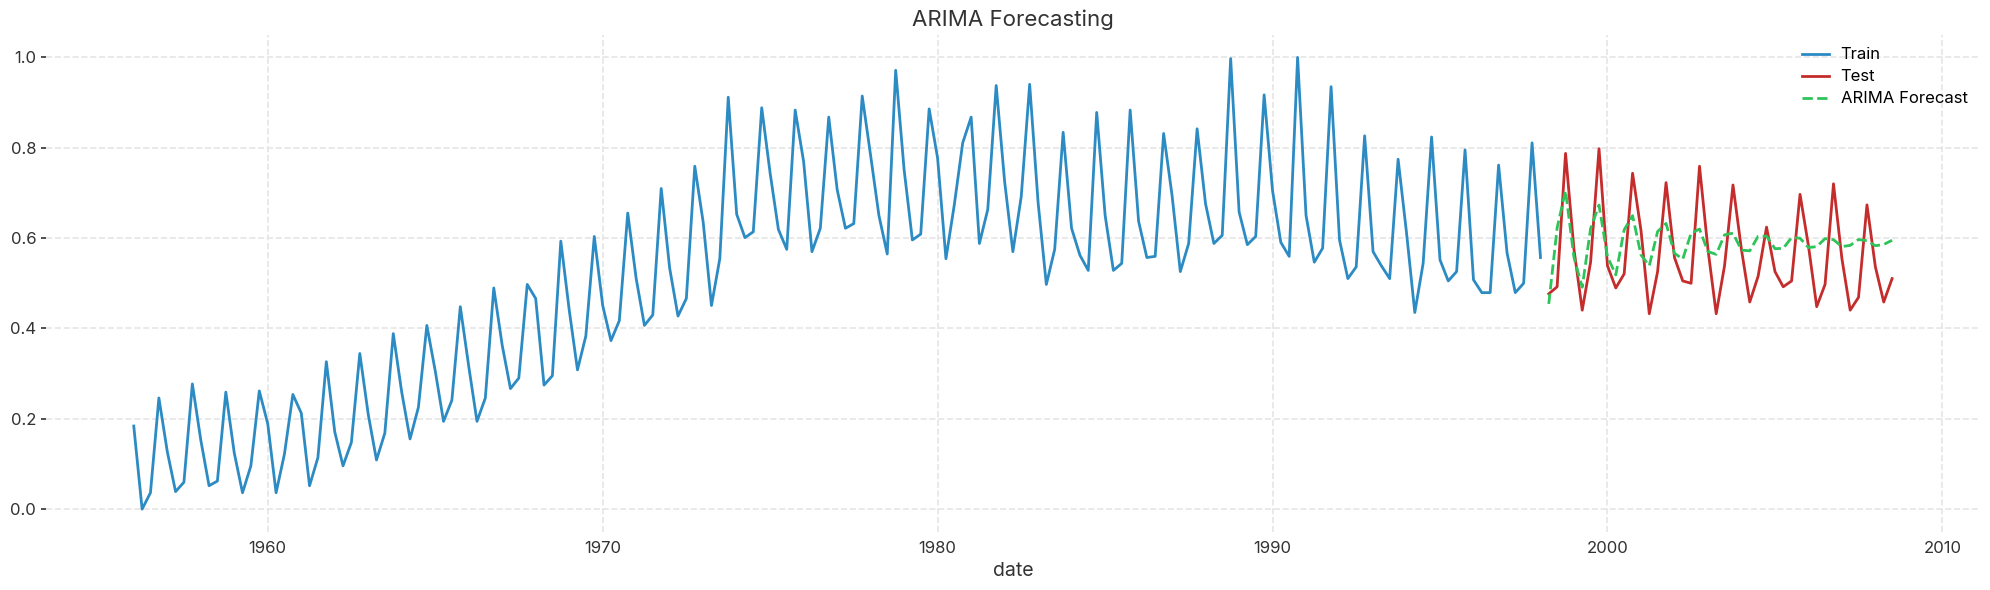

In [7]:
# Fit ARIMA model with specified orders
arima_model = ARIMA(p=2, d=1, q=2)
arima_model.fit(train)

# Forecast
pred_arima = arima_model.predict(len(test))

# Calculate error
mape_arima = mape(test, pred_arima)
rmse_arima = rmse(test, pred_arima)

print(f"ARIMA(2,1,2) MAPE: {mape_arima:.2f}%")
print(f"ARIMA(2,1,2) RMSE: {rmse_arima:.2f}")

# Visualize
plt.figure(figsize=(20, 6))
train.plot(label='Train', color=MyStyle.Palette.BLUE, linewidth=2)
test.plot(label='Test', color=MyStyle.Palette.RED, linewidth=2)
pred_arima.plot(label='ARIMA Forecast', color=MyStyle.Palette.GREEN, linewidth=2, linestyle='--')
plt.title('ARIMA Forecasting')
plt.legend()
MyStyle().apply()
plt.tight_layout()
plt.show()

**Interpretation:**
ARIMA models temporal dependencies effectively. The differencing (I) component makes the series stationary, while AR and MA capture patterns in the data and residuals respectively.

#### 3.2.2 SARIMA (Seasonal ARIMA)

SARIMA extends ARIMA by explicitly modeling seasonal patterns. It's ideal for data with recurring cycles (monthly, quarterly, etc.).

**Mathematical Formulation:**

SARIMA(p,d,q)(P,D,Q)$_s$ is defined as:

$$
(1 - \phi_{1}B)~(1 - \Phi_{1}B^{s}) (1 - B) (1 - B^{s})y_{t} =
  (1 + \theta_{1}B)~ (1 + \Theta_{1}B^{s})\varepsilon_{t}.
$$

where:
- $(p,d,q)$ = non-seasonal orders
- $(P,D,Q)$ = seasonal orders
- $s$ = seasonal period (e.g., 12 for monthly data)


SARIMA(1,1,1)(1,1,1,12) MAPE: 9.50%


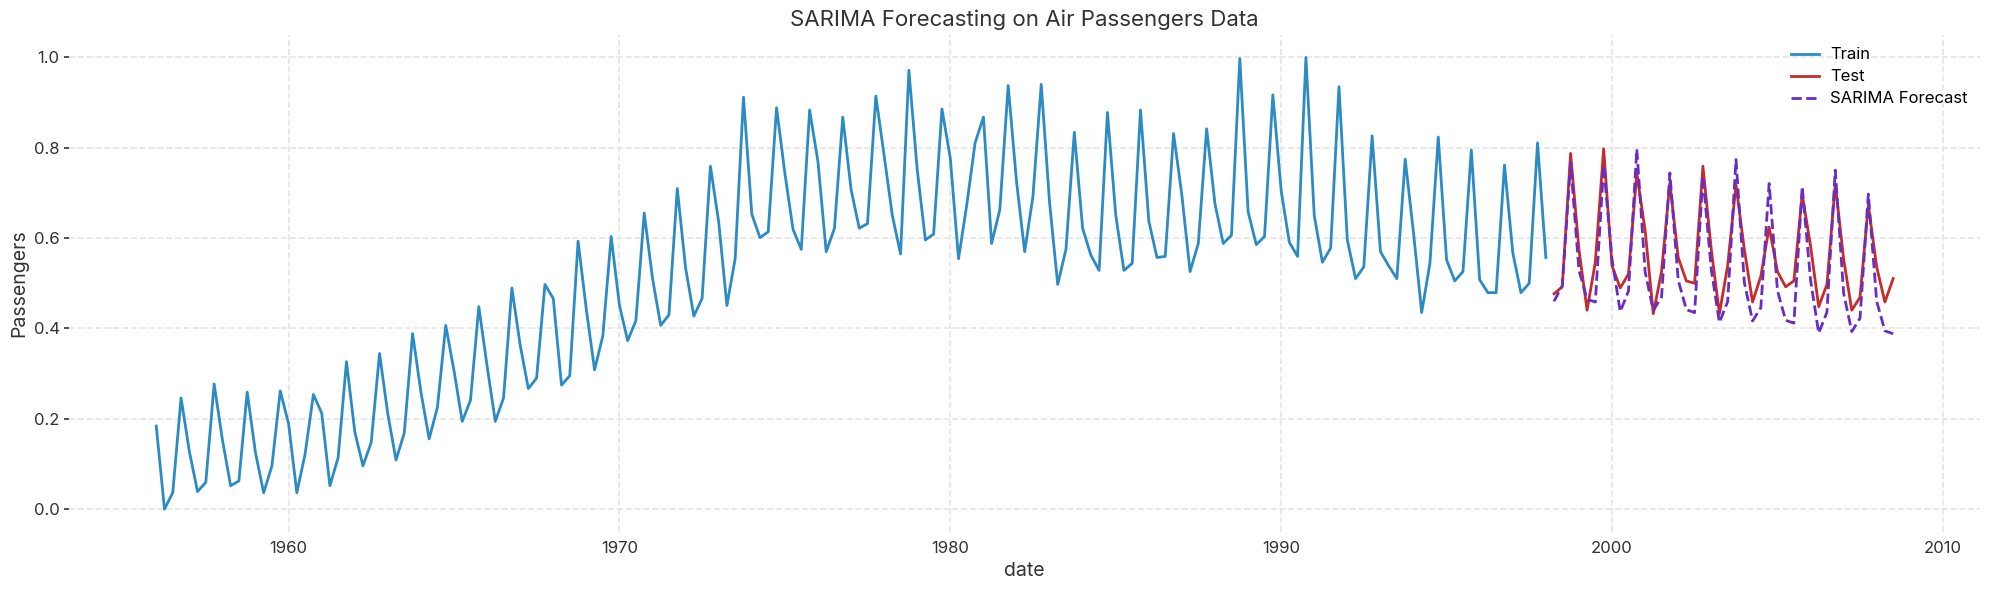

In [8]:
# Fit SARIMA with seasonal period of 12 (monthly data)
# SARIMA(1,1,1)(1,1,1,12)
from darts.models import ARIMA as SARIMA_Model

sarima_model = SARIMA_Model(
    p=1, d=1, q=1,           # Non-seasonal orders
    seasonal_order=(1, 1, 1, 12)  # (P, D, Q, s) - monthly seasonality
)
sarima_model.fit(train)

# Forecast
pred_sarima = sarima_model.predict(len(test))

# Calculate error
mape_sarima = mape(test, pred_sarima)
print(f"SARIMA(1,1,1)(1,1,1,12) MAPE: {mape_sarima:.2f}%")

# Visualize
plt.figure(figsize=(20, 6))
train.plot(label='Train', color=MyStyle.Palette.BLUE, linewidth=2)
test.plot(label='Test', color=MyStyle.Palette.RED, linewidth=2)
pred_sarima.plot(label='SARIMA Forecast', color=MyStyle.Palette.PURPLE, linewidth=2, linestyle='--')
plt.title('SARIMA Forecasting on Air Passengers Data')
plt.ylabel('Passengers')
plt.legend()
MyStyle().apply()
plt.tight_layout()
plt.show()

**Interpretation:**
SARIMA explicitly models seasonal patterns, making it superior to ARIMA for data with recurring cycles. The dataset shows strong yearly seasonality, which SARIMA captures effectively.

#### 3.2.3 Prophet
Prophet is a decomposable time series model developed by Facebook, designed to handle seasonality, holidays, and trend changes effectively.

**Mathematical Formulation:**
$$
y(t) = g(t) + s(t) + h(t) + \epsilon_t
$$
where:
- $g(t)$: trend function modeling non-periodic changes
- $s(t)$: seasonality function modeling periodic changes
- $h(t)$: holiday effects
- $\epsilon_t$: error term  


00:50:10 - cmdstanpy - INFO - Chain [1] start processing
00:50:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE: 6.51%


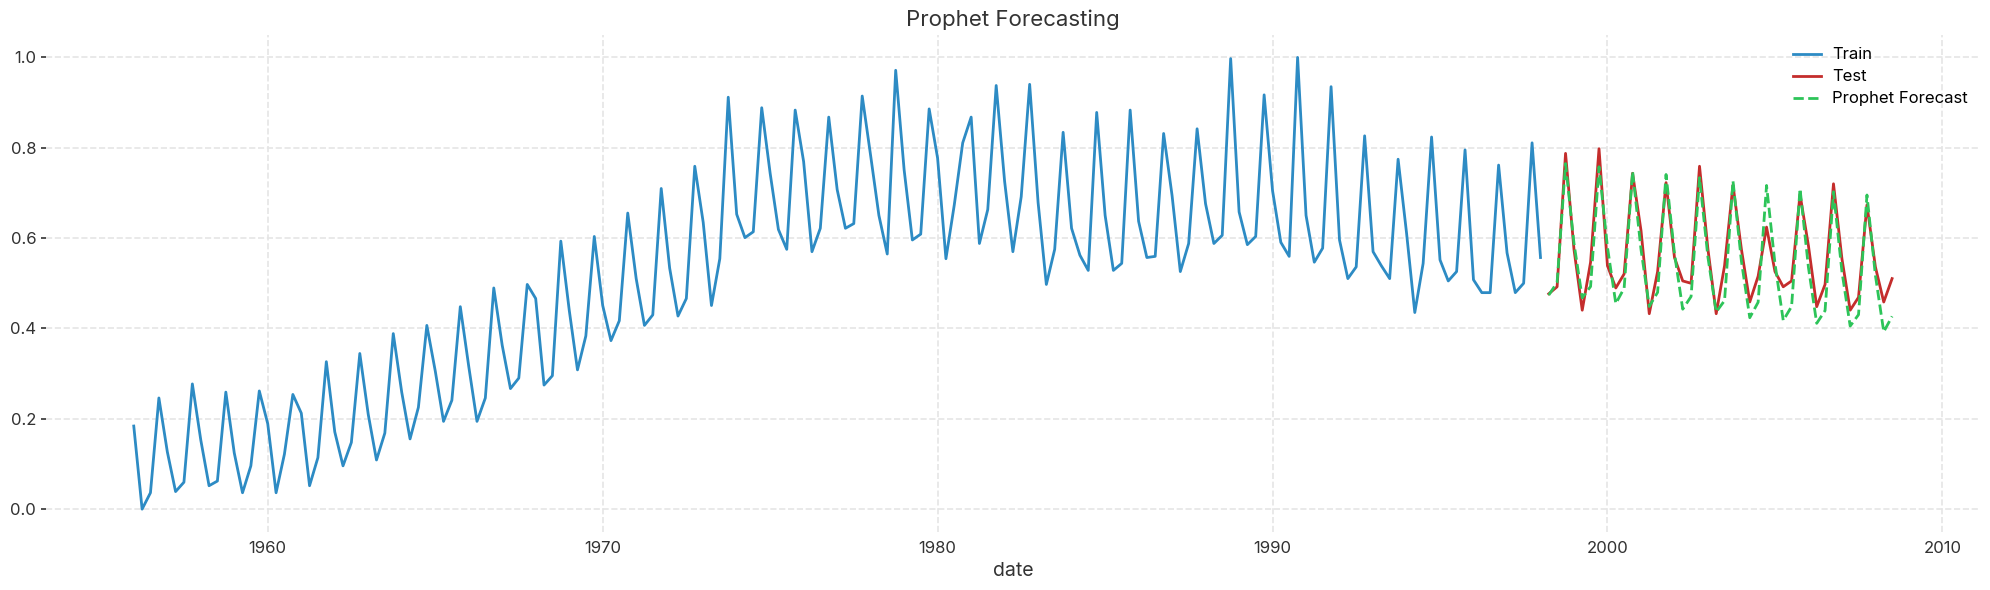

In [9]:
from darts.models import Prophet

# Initialize the Prophet model
prophet_model = Prophet()

# Fit the model on the training data
prophet_model.fit(train)

# Predict on the test set
pred_prophet = prophet_model.predict(len(test))

# Calculate the MAPE for Prophet predictions
mape_prophet = mape(test, pred_prophet)
print(f"Prophet MAPE: {mape_prophet:.2f}%")

# Visualize the results
plt.figure(figsize=(20, 6))
train.plot(label='Train', color=MyStyle.Palette.BLUE, linewidth=2)
test.plot(label='Test', color=MyStyle.Palette.RED, linewidth=2)
pred_prophet.plot(label='Prophet Forecast', color=MyStyle.Palette.GREEN, linewidth=2, linestyle='--')
plt.title('Prophet Forecasting')
plt.legend()
MyStyle().apply()
plt.tight_layout()
plt.show()

**Interpretation:**
Prophet is user-friendly and handles missing data and outliers well. It is particularly effective for business time series with strong seasonal effects and holiday impacts.

### 3.3 Regression-Based Forecasting

Linear regression can be applied to time series by engineering features from time indices and lagged values.

**Mathematical Formulation:**

$$
y_t = \beta_0 + \beta_1 t + \beta_2 y_{t-1} + \beta_3 y_{t-2} + ... + \beta_k y_{t-k} + \epsilon_t
$$

where:
- $t$ = time index
- $y_{t-i}$ = lagged values (autoregressive features)
- $\beta_i$ = regression coefficients
- $\epsilon_t$ = error term

The model learns relationships between features (time, lags, etc.) and the target variable.

Linear Regression MAPE: 12.76%


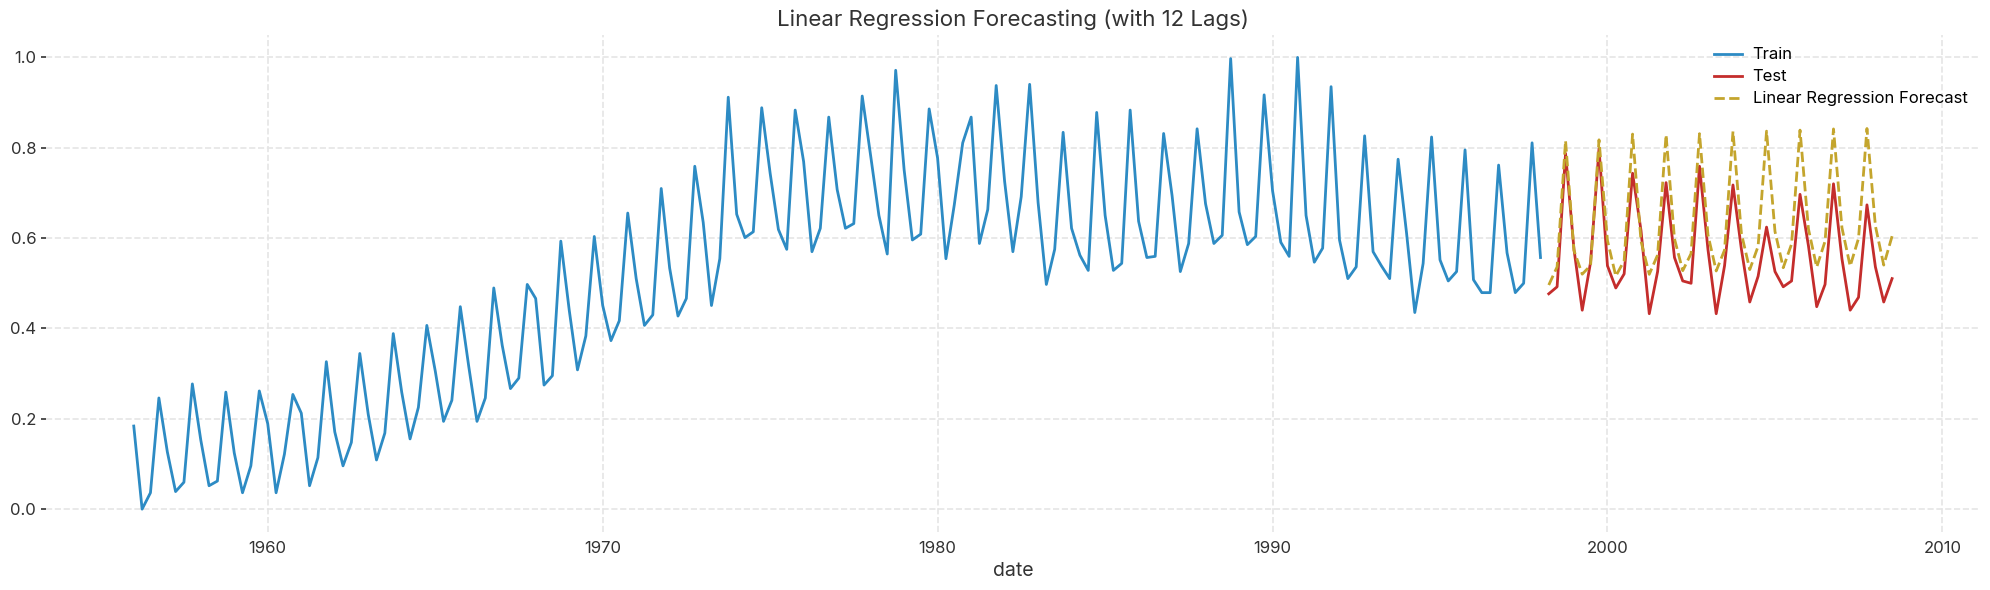

In [10]:
# Linear Regression with lagged features
# lags parameter creates autoregressive features
lr_model = LinearRegressionModel(lags=12, output_chunk_length=1)
lr_model.fit(train)

# Forecast
pred_lr = lr_model.predict(len(test))

# Calculate error
mape_lr = mape(test, pred_lr)
print(f"Linear Regression MAPE: {mape_lr:.2f}%")

# Visualize
plt.figure(figsize=(20, 6))
train.plot(label='Train', color=MyStyle.Palette.BLUE, linewidth=2)
test.plot(label='Test', color=MyStyle.Palette.RED, linewidth=2)
pred_lr.plot(label='Linear Regression Forecast', color=MyStyle.Palette.YELLOW_ORANGE, linewidth=2, linestyle='--')
plt.title('Linear Regression Forecasting (with 12 Lags)')
plt.legend()
MyStyle().apply()
plt.tight_layout()
plt.show()

**Interpretation:**
Linear regression is simple and interpretable. By using lagged values as features, it captures autoregressive patterns. However, it assumes linear relationships and may struggle with complex non-linear patterns.

### 3.4 LSTM/RNN Forecasting

Recurrent Neural Networks (RNNs), particularly Long Short-Term Memory (LSTM) networks, excel at capturing long-term dependencies in sequential data.

**Mathematical Formulation:**

For an LSTM cell at time $t$:

$$
\begin{align*}
\text{Forget gate: } \quad f_t &= \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \\
\text{Input gate: } \quad i_t &= \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
\text{Candidate: } \quad \tilde{C}_t &= \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) \\
\text{Cell state: } \quad C_t &= f_t \odot C_{t-1} + i_t \odot \tilde{C}_t \\
\text{Output gate: } \quad o_t &= \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
\text{Hidden state: } \quad h_t &= o_t \odot \tanh(C_t)
\end{align*}
$$

where:
- $\sigma$ = sigmoid activation
- $\tanh$ = hyperbolic tangent
- $\odot$ = element-wise multiplication
- $W$ and $b$ = weight matrices and biases
- $h_t$ = hidden state (output)
- $C_t$ = cell state (memory)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training LSTM model (this may take a minute)...


`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.77it/s]
LSTM MAPE: 20.94%


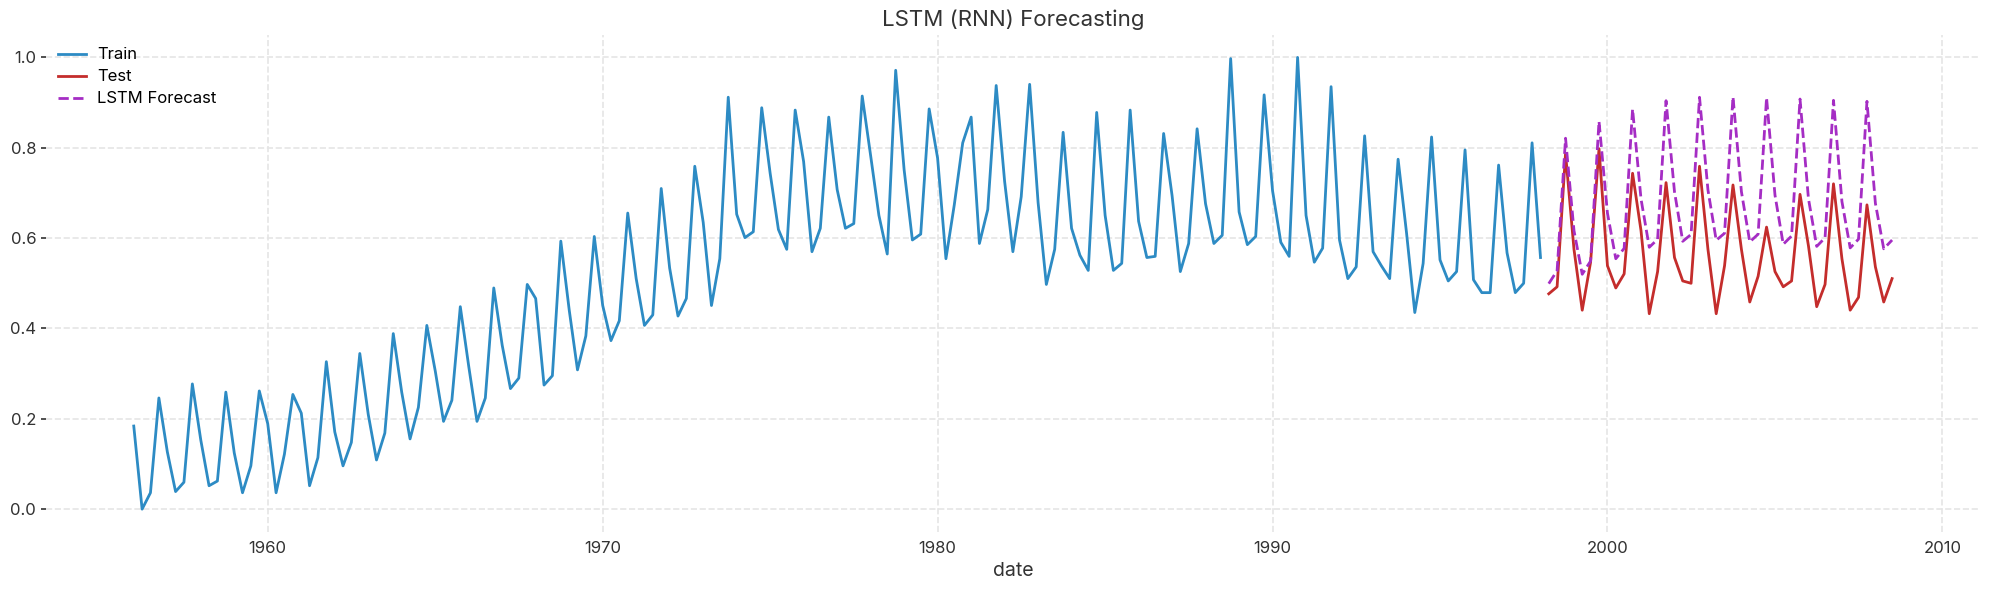

In [ ]:
# RNN/LSTM Model
# Note: Training may take longer than statistical methods
rnn_model = RNNModel(
    model='LSTM',
    hidden_dim=16,
    n_rnn_layers=2,
    input_chunk_length=24,    # Look back 30 time steps
    training_length=24,        # Training sequence length
    n_epochs=500,               # Number of training epochs
    batch_size=16,
    random_state=42,
)

# Scale data for neural networks (important!)
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

train_scaled = train_scaled.astype(np.float32)
test_scaled = test_scaled.astype(np.float32)

# Fit model
print("Training LSTM model (this may take a minute)...")
rnn_model.fit(train_scaled, verbose=False)

# Forecast and inverse transform
pred_rnn_scaled = rnn_model.predict(len(test))
pred_rnn = scaler.inverse_transform(pred_rnn_scaled)

# Calculate error
mape_rnn = mape(test, pred_rnn)
print(f"LSTM MAPE: {mape_rnn:.2f}%")

# Visualize
plt.figure(figsize=(20, 6))
train.plot(label='Train', color=MyStyle.Palette.BLUE, linewidth=2)
test.plot(label='Test', color=MyStyle.Palette.RED, linewidth=2)
pred_rnn.plot(label='LSTM Forecast', color=MyStyle.Palette.MAGENTA, linewidth=2, linestyle='--')
plt.title('LSTM (RNN) Forecasting')
plt.legend()
MyStyle().apply()
plt.tight_layout()
plt.show()

**Interpretation:**
LSTMs can learn complex non-linear patterns and long-term dependencies. **They require more data** and computational resources than statistical methods, but can achieve superior performance on complex time series. In this case it struggles becouse the data is univariate and the data is not enough. Data scaling is critical for neural network training.

## 4. Anomaly Detection Methods ⏰

Anomaly detection identifies unusual patterns or outliers in time series data. These can indicate system failures, fraud, or other significant events.

### 4.1 Dataset Preparation

In [11]:
# make a dataset with anomalies
import numpy as np
from darts import TimeSeries

# Create a synthetic time series with anomalies
time_index = pd.date_range(start='2020-01-01', periods=200, freq='D')
data = np.sin(np.linspace(0, 20 * np.pi, 200)) + np.random.normal(0, 0.5, 200)
# Introduce anomalies
anomaly_indices = np.random.choice(200, size=10, replace=False)
data[anomaly_indices] += np.random.normal(10, 2, size=10)
series = TimeSeries.from_times_and_values(time_index, data, fill_missing_dates=True, freq='D')


### 4.2 Z-Score / Rolling Statistics

Statistical approach using standard deviation to identify points that deviate significantly from the mean.

**Mathematical Formulation:**

The Z-score for a value $x_t$ is:

$$
z_t = \frac{x_t - \mu}{\sigma}
$$

For **rolling statistics** (more adaptive to local changes):

$$
z_t = \frac{x_t - \mu_{\text{window}}}{\sigma_{\text{window}}}
$$

where $\mu_{\text{window}}$ and $\sigma_{\text{window}}$ are computed over a sliding window.

**Anomaly criterion:**
$$
\text{Anomaly if } |z_t| > \text{threshold} \quad \text{(typically 3)}
$$

This method assumes data follows a normal distribution and flags points beyond a certain number of standard deviations.

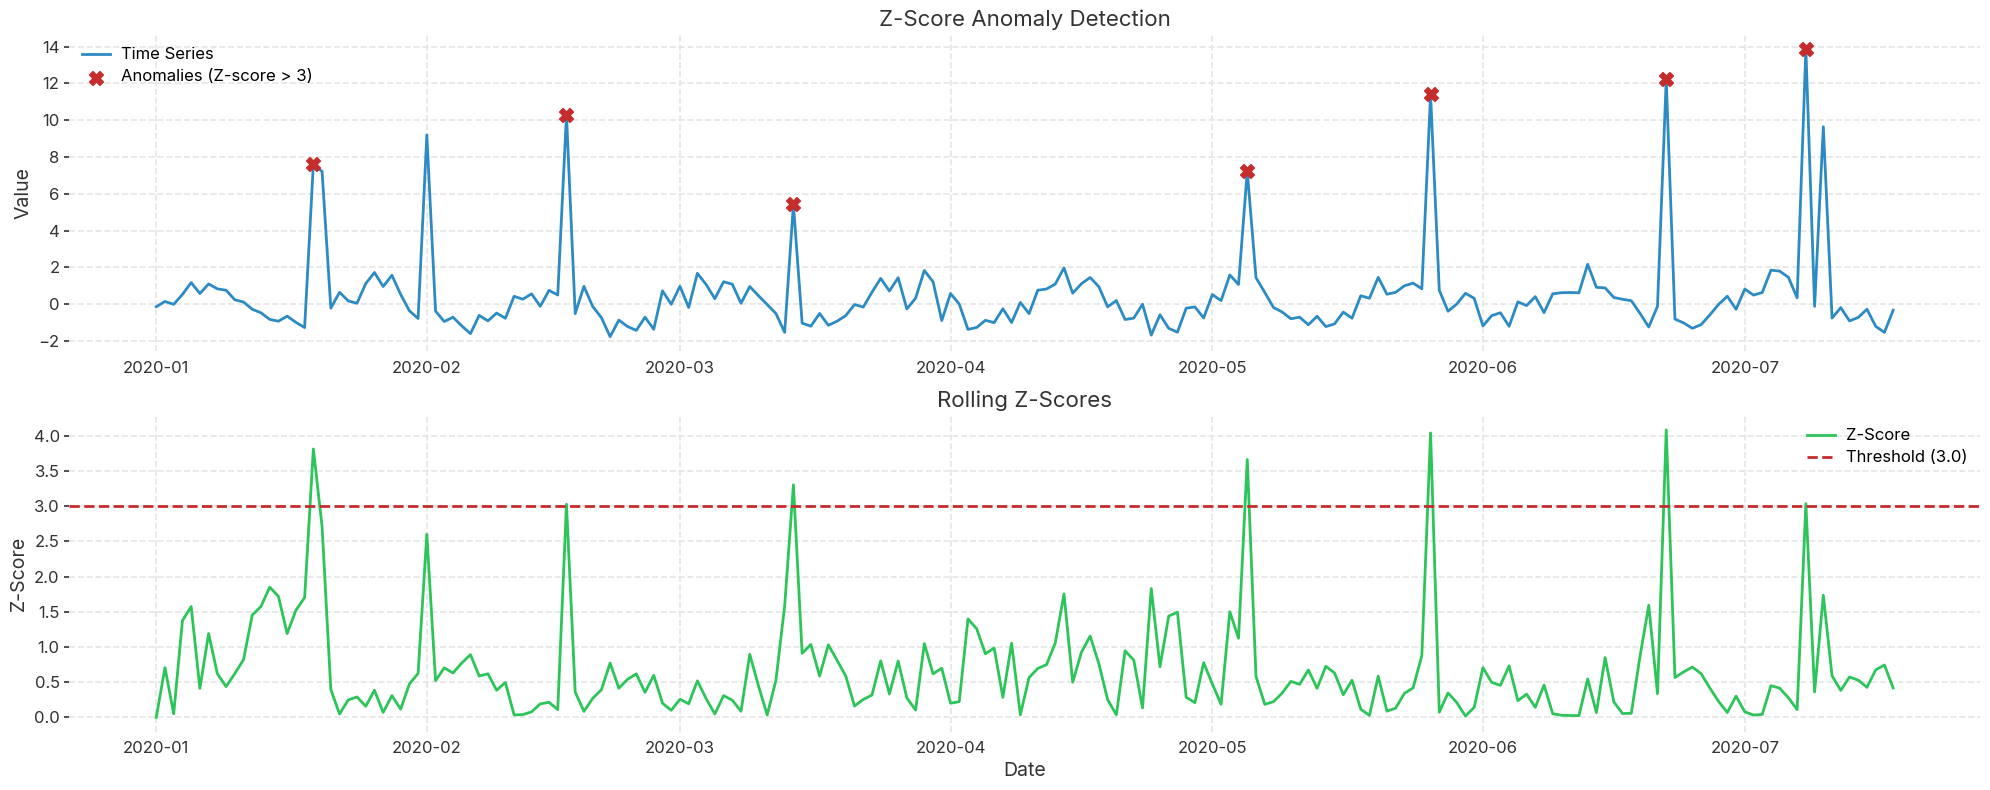

Detected 7 anomalies using Z-score method


In [12]:
# Z-Score based anomaly detection using rolling statistics
# Use the `series` TimeSeries created in the previous cell as the input
# Convert to pandas 1D series for rolling statistics
df = series.to_dataframe().iloc[:, 0]

window_size = 20
rolling_mean = df.rolling(window=window_size, min_periods=1).mean()
rolling_std = df.rolling(window=window_size, min_periods=1).std().fillna(1e-8)

# Compute z-scores (absolute)
z_scores = ((df - rolling_mean).abs()) / (rolling_std + 1e-8)

# Flag anomalies (|z| > threshold)
threshold = 3.0
anomalies_zscore = z_scores > threshold

# Visualize
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(df.index, df.values, label='Time Series', color=MyStyle.Palette.BLUE, linewidth=2)
ax1.scatter(df.index[anomalies_zscore.values], df.values[anomalies_zscore.values], color=MyStyle.Palette.RED, s=100, 
            label='Anomalies (Z-score > 3)', zorder=5, marker='X')
ax1.set_title('Z-Score Anomaly Detection')
ax1.set_ylabel('Value')
ax1.legend()

ax2 = plt.subplot(2, 1, 2)
ax2.plot(z_scores.index, z_scores.values, color=MyStyle.Palette.GREEN, linewidth=2, label='Z-Score')
ax2.axhline(y=threshold, color=MyStyle.Palette.RED, linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
ax2.set_title('Rolling Z-Scores')
ax2.set_ylabel('Z-Score')
ax2.set_xlabel('Date')
ax2.legend()

MyStyle().apply(axes=[ax1, ax2])
plt.tight_layout()
plt.show()

print(f"Detected {int(anomalies_zscore.sum())} anomalies using Z-score method")

**Interpretation:**
Z-score detection is simple and interpretable. Rolling windows make it adaptive to local changes in mean and variance. Works well for normally distributed data but may miss anomalies in non-stationary series.

### 4.3 ARIMA Residual-Based Detection

Uses ARIMA model residuals (prediction errors) to detect anomalies. Large residuals indicate points the model couldn't predict well.

**Mathematical Formulation:**

1. Fit ARIMA model

2. Calculate residuals:
$$
r_t = y_t - \hat{y}_t
$$

3. Standardize residuals:
$$
z_t = \frac{r_t - \mu_r}{\sigma_r}
$$

4. Flag anomalies:
$$
\text{Anomaly if } |z_t| > \text{threshold}
$$

Points with large residuals indicate the model failed to capture the pattern, suggesting an anomaly.

/Users/jack/.envs/ts/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


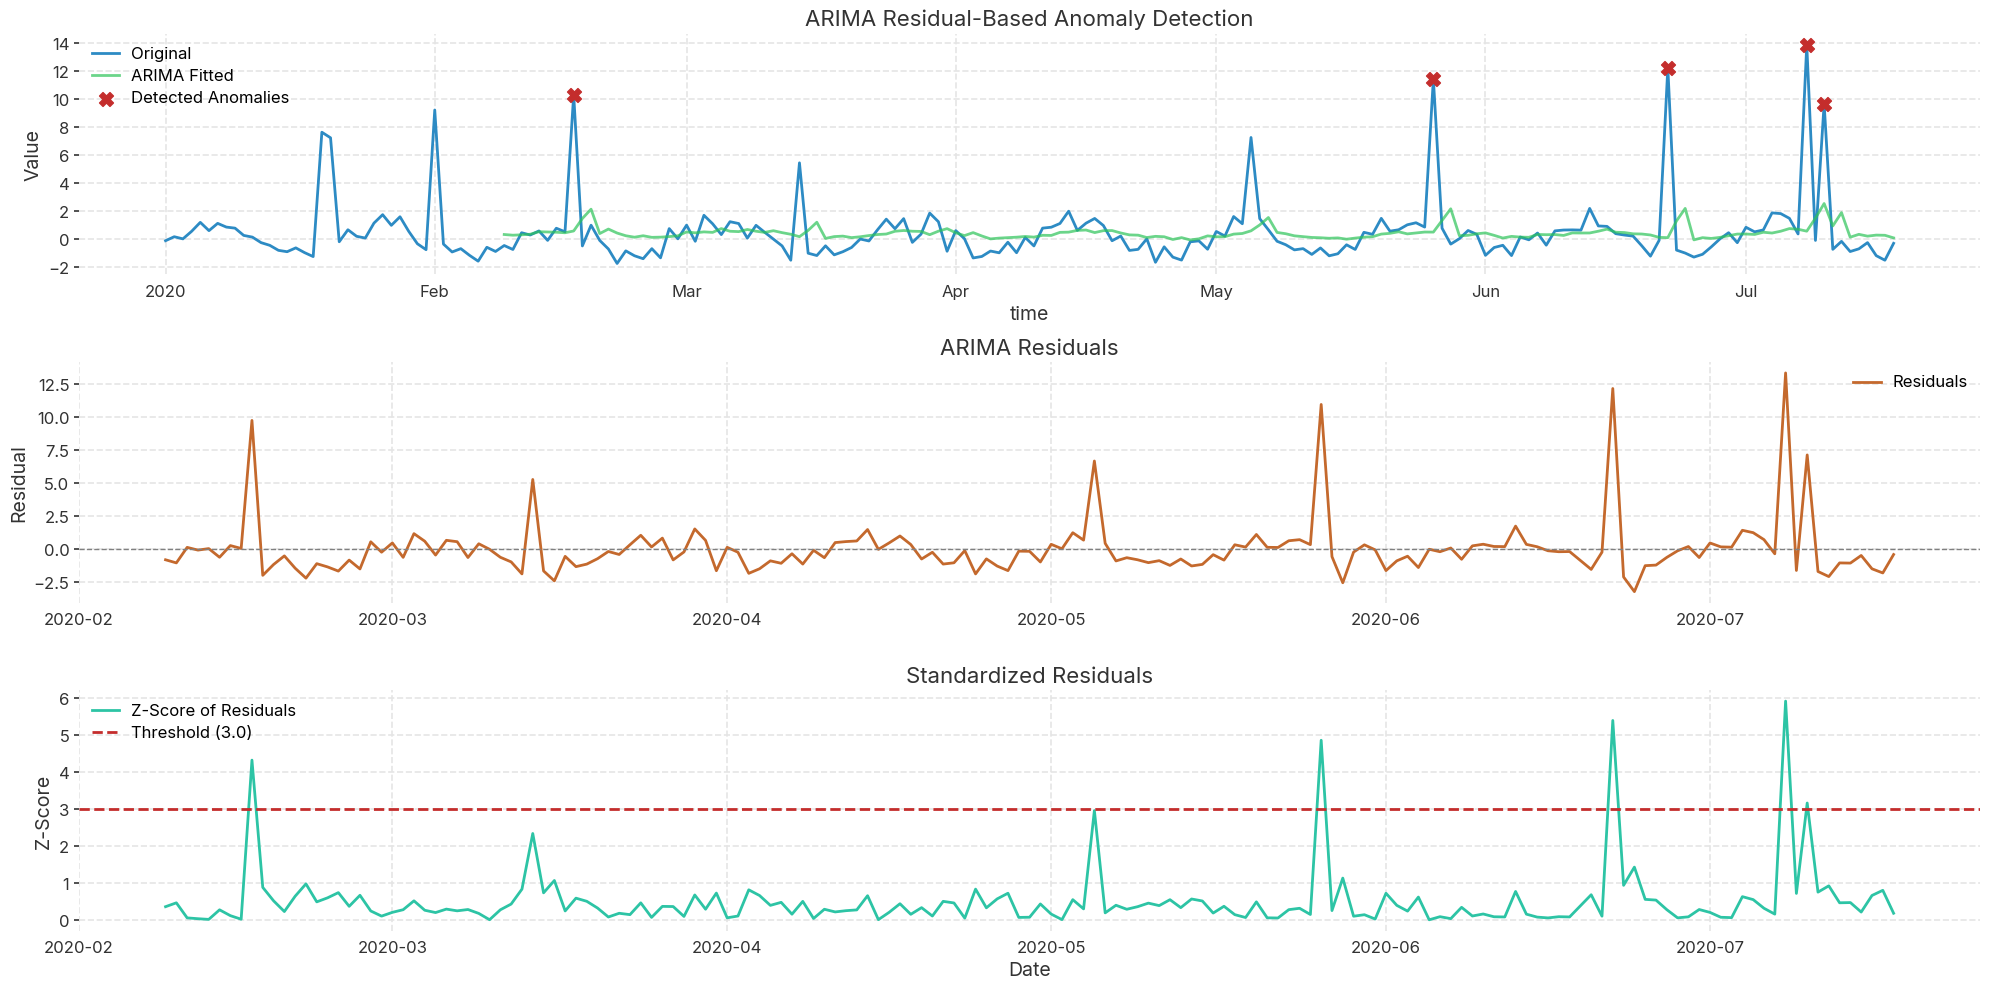

Detected 5 anomalies using ARIMA residuals


In [ ]:
# ARIMA Residual-based Anomaly Detection
from darts.models import ARIMA
import numpy as np
import matplotlib.pyplot as plt

# Fit ARIMA on entire series and compute one-step-ahead historical forecasts to obtain residuals
arima_full = ARIMA(p=2, d=1, q=2)
arima_full.fit(series)

# Use historical_forecasts to get one-step-ahead predictions aligned with the observed series
fitted_values = arima_full.historical_forecasts(
    series,
    start=0.2,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    verbose=False
)

# Align observed and fitted values and compute residuals
aligned_obs = series.slice_intersect(fitted_values)
residuals_series = aligned_obs - fitted_values
residuals = residuals_series.values().flatten()

# Standardize residuals
resid_mean = np.mean(residuals)
resid_std = np.std(residuals) + 1e-8
z_residuals = np.abs((residuals - resid_mean) / resid_std)

# Flag anomalies
threshold_resid = 3.0
anomalies_residual = z_residuals > threshold_resid

anomaly_times = residuals_series.time_index[anomalies_residual]
anomaly_vals = aligned_obs.values()[anomalies_residual].flatten()

# Visualize
plt.figure(figsize=(20, 10))

ax1 = plt.subplot(3, 1, 1)
series.plot(ax=ax1, label='Original', color=MyStyle.Palette.BLUE, linewidth=2)
fitted_values.plot(ax=ax1, label='ARIMA Fitted', color=MyStyle.Palette.GREEN, linewidth=2, alpha=0.7)

ax1.scatter(
    anomaly_times,
    anomaly_vals,
    color=MyStyle.Palette.RED,
    s=100,
    label='Detected Anomalies',
    zorder=5,
    marker='X'
)

ax1.set_title('ARIMA Residual-Based Anomaly Detection')
ax1.set_ylabel('Value')
ax1.legend()

# --- residual plot ---
ax2 = plt.subplot(3, 1, 2)
ax2.plot(residuals_series.time_index, residuals,
         color=MyStyle.Palette.ORANGE, linewidth=2, label='Residuals')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)
ax2.set_title('ARIMA Residuals')
ax2.set_ylabel('Residual')
ax2.legend()

# --- z-score plot ---
ax3 = plt.subplot(3, 1, 3)
ax3.plot(residuals_series.time_index, z_residuals,
         color=MyStyle.Palette.CYAN, linewidth=2, label='Z-Score of Residuals')

ax3.axhline(y=threshold_resid,
            color=MyStyle.Palette.RED,
            linestyle='--',
            linewidth=2,
            label=f'Threshold ({threshold_resid})'
)

ax3.set_title('Standardized Residuals')
ax3.set_ylabel('Z-Score')
ax3.set_xlabel('Date')
ax3.legend()

MyStyle().apply(axes=[ax1, ax2, ax3])
plt.tight_layout()
plt.show()

print(f"Detected {int(np.sum(anomalies_residual))} anomalies using ARIMA residuals")


**Interpretation:**
Residual-based detection leverages the forecasting model's prediction errors. Points where the model performs poorly are flagged as anomalies. This approach is more sophisticated than simple statistical methods as it accounts for temporal patterns.

### 4.4 STL Decomposition Anomaly Detection

Seasonal-Trend decomposition using Loess (STL) separates a time series into trend, seasonal, and residual components. Anomalies are detected in the residual component.

**Mathematical Formulation:**

STL decomposes a time series as:
$$
y_t = T_t + S_t + R_t
$$

where:
- $T_t$ = trend component
- $S_t$ = seasonal component
- $R_t$ = residual (remainder) component

**Anomaly detection:**
$$
z_t = \frac{R_t - \mu_R}{\sigma_R}
$$

$$
\text{Anomaly if } |z_t| > \text{threshold}
$$

The residual component captures variations not explained by trend or seasonality, making it ideal for anomaly detection.

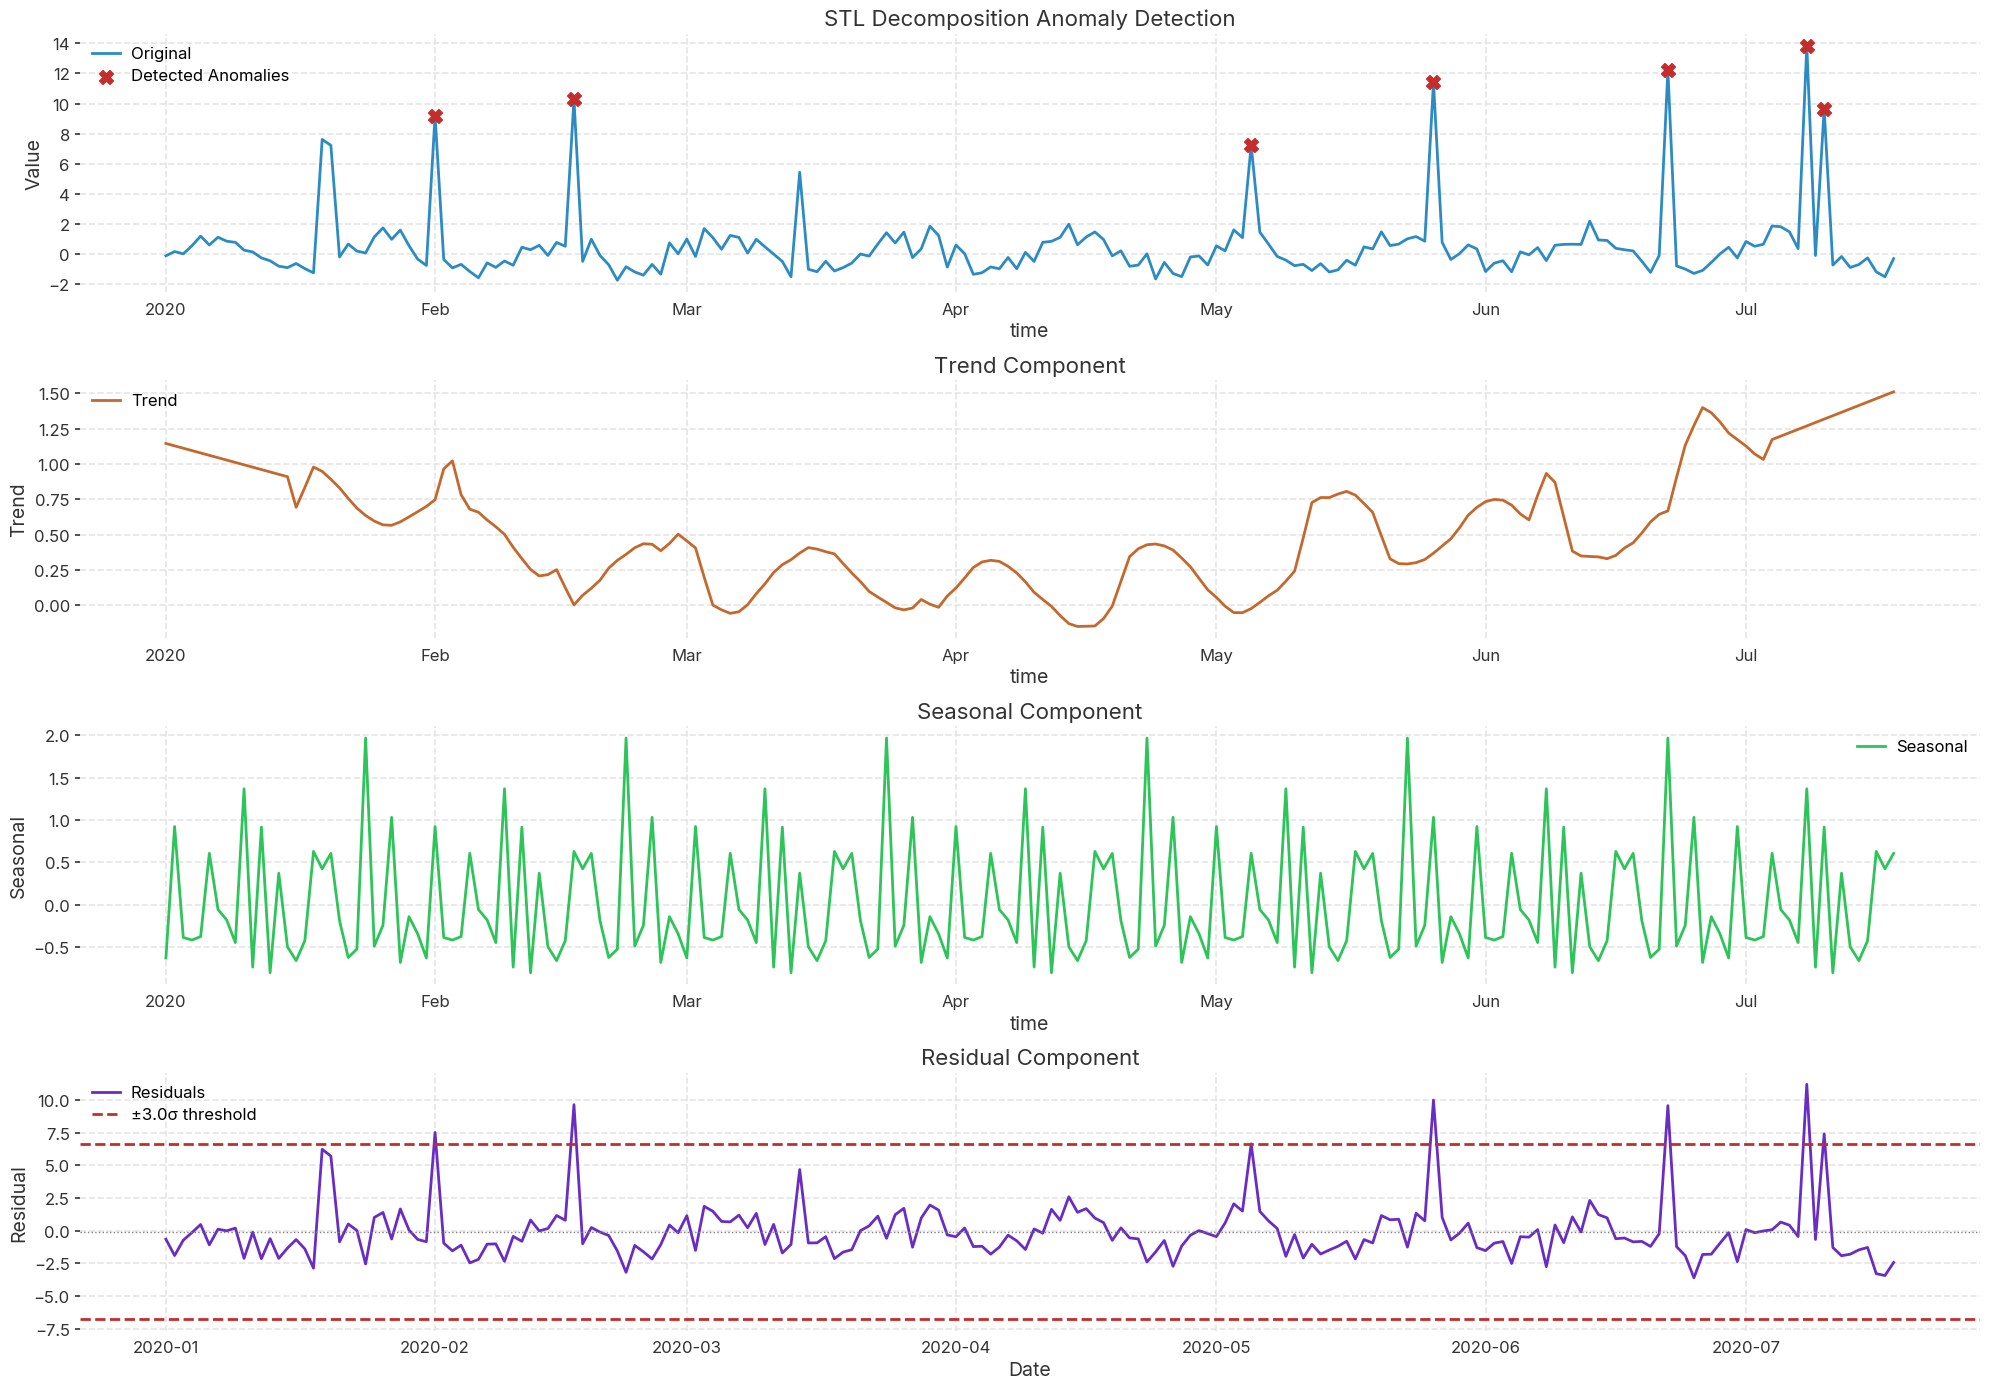

Detected 7 anomalies using STL decomposition


In [18]:
# STL Decomposition for Anomaly Detection
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode, SeasonalityMode

# Decompose using STL
trend_stl, seasonal_stl = extract_trend_and_seasonality(
    series, 
    freq=30,   
    model=ModelMode.ADDITIVE
)

# Calculate residuals
residual_stl = series - trend_stl - seasonal_stl
resid_values = residual_stl.values().flatten()

# Standardize residuals for anomaly detection
resid_mean = np.mean(resid_values)
resid_std = np.std(resid_values) + 1e-8
z_stl = np.abs((resid_values - resid_mean) / resid_std)

# Flag anomalies
threshold_stl = 3.0
anomalies_stl = z_stl > threshold_stl

# ---- FIX: safe anomaly values using boolean indexing ----
anomaly_times_stl = residual_stl.time_index[anomalies_stl]
anomaly_vals_stl = series.values()[anomalies_stl].flatten()

# Visualize
fig, axes = plt.subplots(4, 1, figsize=(20, 14))

# Original series with detected anomalies
series.plot(ax=axes[0], label='Original', color=MyStyle.Palette.BLUE, linewidth=2)

axes[0].scatter(
    anomaly_times_stl,
    anomaly_vals_stl,
    color=MyStyle.Palette.RED,
    s=100,
    label='Detected Anomalies',
    zorder=5,
    marker='X'
)

axes[0].set_title('STL Decomposition Anomaly Detection')
axes[0].set_ylabel('Value')
axes[0].legend()

# Trend component
trend_stl.plot(ax=axes[1], label='Trend', color=MyStyle.Palette.ORANGE, linewidth=2)
axes[1].set_title('Trend Component')
axes[1].set_ylabel('Trend')
axes[1].legend()

# Seasonal component
seasonal_stl.plot(ax=axes[2], label='Seasonal', color=MyStyle.Palette.GREEN, linewidth=2)
axes[2].set_title('Seasonal Component')
axes[2].set_ylabel('Seasonal')
axes[2].legend()

# Residual component with anomaly threshold
axes[3].plot(
    residual_stl.time_index,
    resid_values,
    color=MyStyle.Palette.PURPLE,
    linewidth=2,
    label='Residuals'
)

axes[3].axhline(
    y=resid_mean + threshold_stl * resid_std,
    color=MyStyle.Palette.RED,
    linestyle='--',
    linewidth=2,
    label=f'±{threshold_stl}σ threshold'
)

axes[3].axhline(
    y=resid_mean - threshold_stl * resid_std,
    color=MyStyle.Palette.RED,
    linestyle='--',
    linewidth=2
)

axes[3].axhline(y=resid_mean, color='gray', linestyle=':', linewidth=1)

axes[3].set_title('Residual Component')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')
axes[3].legend()

MyStyle().apply(axes=axes)
plt.tight_layout()
plt.show()

print(f"Detected {int(np.sum(anomalies_stl))} anomalies using STL decomposition")


**Interpretation:**
STL decomposition cleanly separates trend, seasonality, and irregular components. By analyzing residuals after removing predictable patterns, we can more accurately identify true anomalies rather than expected variations.

### 4.5 Autoencoder-Based Anomaly Detection

Autoencoders are neural networks trained to reconstruct input data. High reconstruction error indicates anomalies—patterns the model hasn't learned.

**Mathematical Formulation:**

An autoencoder consists of:

**Encoder:**
$$
h = f_{\text{enc}}(x; \theta_{\text{enc}}) = \sigma(W_{\text{enc}} x + b_{\text{enc}})
$$

**Decoder:**
$$
\hat{x} = f_{\text{dec}}(h; \theta_{\text{dec}}) = \sigma(W_{\text{dec}} h + b_{\text{dec}})
$$

**Reconstruction error:**
$$
e = \|x - \hat{x}\|^2
$$

**Training objective (minimize):**
$$
\mathcal{L} = \frac{1}{n}\sum_{i=1}^{n} \|x_i - \hat{x}_i\|^2
$$

**Anomaly detection:**
$$
\text{Anomaly if } e > \text{threshold}
$$

Normal patterns have low reconstruction error; anomalies have high error as the model hasn't learned to reconstruct them.

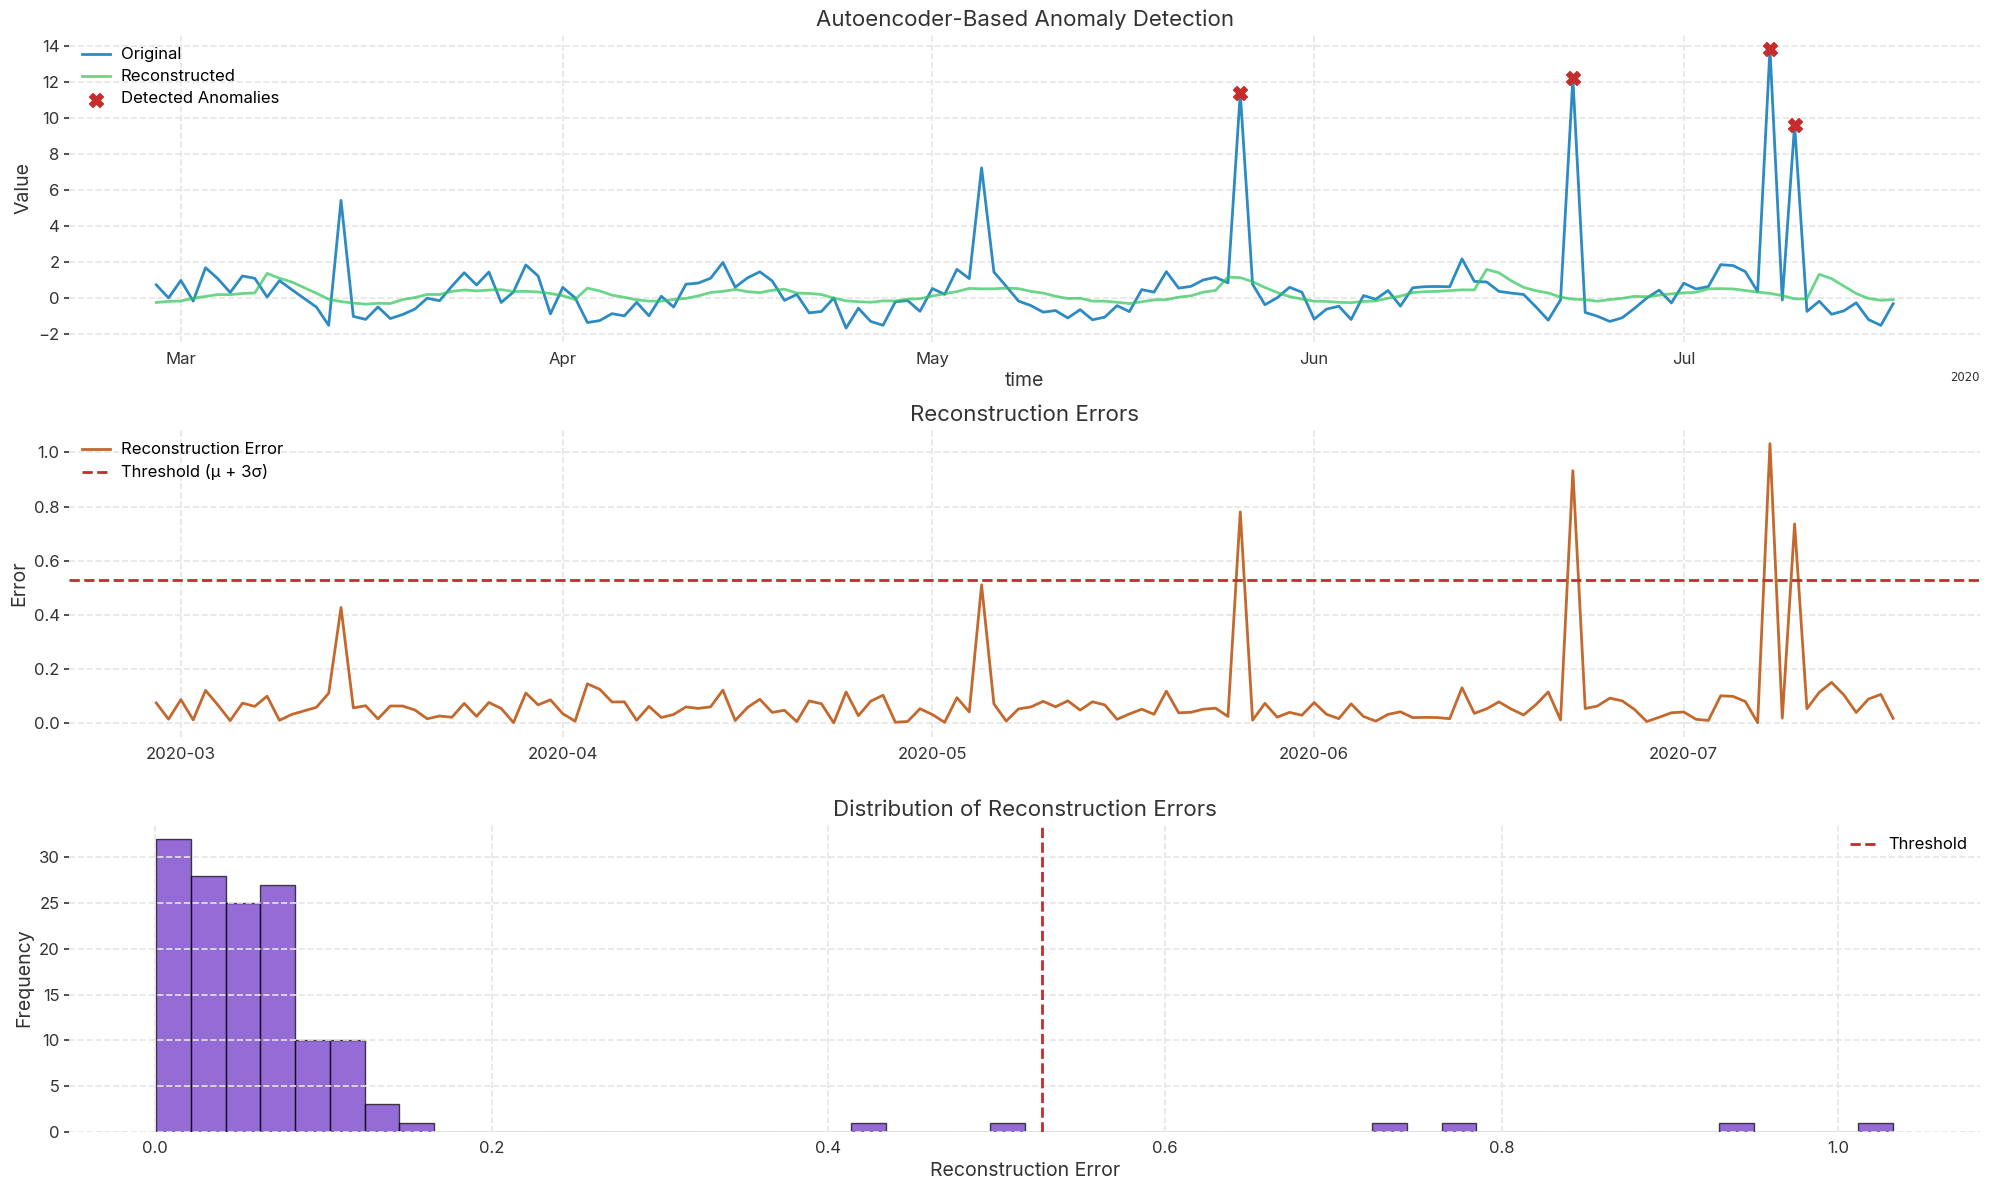

Detected 4 anomalies using autoencoder reconstruction error
Mean reconstruction error: 0.0821, Std: 0.1483


In [ ]:
# Autoencoder-based Anomaly Detection using RNN (BlockRNNModel as simple autoencoder) 
# Use series as the input TimeSeries 
# Train autoencoder on first 80% as "normal" 

series = series.astype(np.float32)
train_normal = series.split_after(0.8)[0] # Scale data
scaler_ae = Scaler() 
train_normal_scaled = scaler_ae.fit_transform(train_normal) 
series_scaled = scaler_ae.transform(series) 
# Build RNN-based autoencoder
autoencoder = BlockRNNModel( model='LSTM', input_chunk_length=20,
                            output_chunk_length=20, # reconstruct same-length chunks
                            hidden_dim=32, 
                            n_rnn_layers=1,
                            n_epochs=30,
                            batch_size=16,
                            random_state=42 )
print("Training autoencoder (this may take a minute)...") 

autoencoder.fit(train_normal_scaled, verbose=False)

# Generate reconstructions using historical forecasts
reconstructed = autoencoder.historical_forecasts( series_scaled,
                                                 start=0.2, 
                                                 forecast_horizon=autoencoder.output_chunk_length,
                                                 stride=1, retrain=False,
                                                 verbose=False, overlap_end=True )

common_series = series_scaled.slice_intersect(reconstructed)
reconstructed_aligned = reconstructed.slice_intersect(common_series)

diff_vals = common_series.values() - reconstructed_aligned.values()
abs_diff_vals = np.abs(diff_vals)
reconstruction_errors = common_series.with_values(abs_diff_vals)

errors = abs_diff_vals.flatten()

# Detect anomalies
error_mean = np.mean(errors)
error_std = np.std(errors)
threshold_ae = error_mean + 3 * error_std
anomalies_ae = errors > threshold_ae

# Visualization setup
fig, axes = plt.subplots(3, 1, figsize=(20, 12))

# Inverse-transform aligned original and reconstruction
orig_aligned = scaler_ae.inverse_transform(common_series)
recon_aligned = scaler_ae.inverse_transform(reconstructed_aligned)

# Plot original + reconstructed
orig_aligned.plot(ax=axes[0], label='Original', color=MyStyle.Palette.BLUE, linewidth=2)
recon_aligned.plot(ax=axes[0], label='Reconstructed', color=MyStyle.Palette.GREEN, linewidth=2, alpha=0.7)

# Safe anomaly extraction
anomaly_times_ae = reconstruction_errors.time_index[anomalies_ae]
anomaly_vals_ae = orig_aligned.values()[anomalies_ae].flatten()

axes[0].scatter(
    anomaly_times_ae,
    anomaly_vals_ae,
    color=MyStyle.Palette.RED,
    s=100,
    label='Detected Anomalies',
    zorder=5,
    marker='X'
)

axes[0].set_title('Autoencoder-Based Anomaly Detection')
axes[0].set_ylabel('Value')
axes[0].legend()

# Plot reconstruction errors
axes[1].plot(reconstruction_errors.time_index, errors,
             color=MyStyle.Palette.ORANGE, linewidth=2, label='Reconstruction Error')
axes[1].axhline(
    y=threshold_ae,
    color=MyStyle.Palette.RED,
    linestyle='--',
    linewidth=2,
    label='Threshold (μ + 3σ)'
)
axes[1].set_title('Reconstruction Errors')
axes[1].set_ylabel('Error')
axes[1].legend()

# Error distribution
axes[2].hist(errors, bins=50, color=MyStyle.Palette.PURPLE, alpha=0.7, edgecolor='black')
axes[2].axvline(
    x=threshold_ae,
    color=MyStyle.Palette.RED,
    linestyle='--',
    linewidth=2,
    label='Threshold'
)
axes[2].set_title('Distribution of Reconstruction Errors')
axes[2].set_xlabel('Reconstruction Error')
axes[2].set_ylabel('Frequency')
axes[2].legend()

MyStyle().apply(axes=axes[:2])
plt.tight_layout()
plt.show()

print(f"Detected {int(np.sum(anomalies_ae))} anomalies using autoencoder reconstruction error")
print(f"Mean reconstruction error: {error_mean:.4f}, Std: {error_std:.4f}")


**Interpretation:**
Autoencoders learn to compress and reconstruct normal patterns. They struggle to reconstruct anomalies since these patterns weren't present during training. This unsupervised approach is powerful for detecting novel anomalies without labeled data.

## 5. Further Reading & Resources

- **Darts Documentation**: https://unit8co.github.io/darts/
- **Time Series Analysis Book**: Forecasting: Principles and Practice (https://otexts.com/fpp3/)
